<a href="https://colab.research.google.com/github/achaterlea/london_data/blob/master/ACL_House_Price_Modelling_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# London house price modelling - GT refresh
Andy Chater-Lea

The goal of my project is to apply data science techniques to model house prices based on wider factors about an area which would indicate desirability - for example access to public transport, education, crime and healthcare statistics. I will perform local price modelling at Lower Super Output Area (LSOA) level of granularity. LSOAs are the smallest area unit of measurement used by the government in statistics publically hosted on the London datastore and office of national statistics websites. These areas were drawn geographically in the 2011 census to include ~600 dwellings. I will be using census data and other publically available data I have gathered about about London at this level of granularity as my predictor variables.

## 1. Data collection and preparation

In [1]:
#load relevant libraries for data exploration
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import warnings

%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
#Import census data and check the head. I will primarily be using census data from the most recent (2011) census.
df = pd.read_csv("LSOAdata11.csv", encoding = "ISO-8859-1")

In [3]:
#Set the LSOA as the index, and review data head
df = df.set_index('LSOA')
print (df.shape)
df.head()

(4835, 91)


Name  All Ages  0-15  16-29  30-44  45-64  65+  Working-age  \
LSOA                                                                            
E01000907  Camden 001A      1430   295    257    372    343  163          972   
E01000908  Camden 001B      1581   292    240    431    407  211         1078   
E01000909  Camden 001C      1614   244    291    328    462  289         1081   
E01000912  Camden 001D      1589   260    356    352    395  226         1103   
E01000913  Camden 001E      1710   292    220    343    522  333         1085   

           Working age %  Area (Hectares)  \
LSOA                                        
E01000907         67.972             10.7   
E01000908         68.185             17.5   
E01000909         66.976             22.9   
E01000912         69.415             89.6   
E01000913         63.450            161.7   

                            ...                     Average PTAL Score  \
LSOA                        ...                                          
E01000907                   ...                                    4.6   
E01000908                   ...                                    2.9   
E01000909                   ...                                    3.3   
E01000912                   ...                                    4.6   
E01000913                   ...                                    2.8   

           % 0-1 (poor access)  % 2-3 (average access)  % 4-6 (good access)  \
LSOA                                                                          
E01000907                  0.0                    54.1                 45.9   
E01000908                 33.7                    66.3                  0.0   
E01000909                  0.0                   100.0                  0.0   
E01000912                  0.0                    58.4                 41.6   
E01000913                 27.8                    71.8                  0.5   

           Total Number of Children  \
LSOA                                  
E01000907                       315   
E01000908                       260   
E01000909                       185   
E01000912                       290   
E01000913                       190   

           Total Number of Families Claiming Benefit  \
LSOA                                                   
E01000907                                        180   
E01000908                                        160   
E01000909                                        115   
E01000912                                        160   
E01000913                                        105   

           Number of families with 3+ children  \
LSOA                                             
E01000907                                   35   
E01000908                                   20   
E01000909                                   15   
E01000912                                   30   
E01000913                                   20   

           % of families with 3+ children  \
LSOA                                        
E01000907                            19.4   
E01000908                            12.5   
E01000909                            13.0   
E01000912                            18.8   
E01000913                            19.0   

           Mean Annual Household Income estimate  \
LSOA                                               
E01000907                                  39985   
E01000908                                  42394   
E01000909                                  77370   
E01000912                                  41737   
E01000913                                  96649   

           Median Annual Household Income estimate  
LSOA                                                
E01000907                                    30223  
E01000908                                    32049  
E01000909                                    58469  
E01000912                                    31551  
E01000913                                   

In [4]:
#I have also obtained land Registry data by LSOA detailing the makup of dwellings by type and size
df_landregistry = pd.read_csv("PropertyTypes.csv")
df_landregistry.set_index('LSOA', inplace = True)
print(df_landregistry.shape)
df_landregistry.head()

(4835, 56)


NAME  TYPE_BUNGALOW_1  TYPE_BUNGALOW_2  \
LSOA                                                                     
E01000001        City of London 001A                0                0   
E01000002        City of London 001B                0                0   
E01000003        City of London 001C                0                0   
E01000005        City of London 001E                0                0   
E01000006  Barking and Dagenham 016A                0                0   

           TYPE_BUNGALOW_3  TYPE_BUNGALOW_4  TYPE_BUNGALOW_UNKW  BUNGALOW  \
LSOA                                                                        
E01000001                0                0                   0         0   
E01000002                0                0                   0         0   
E01000003                0                0                   0         0   
E01000005                0                0                   0         0   
E01000006                0                0                   0         0   

           TYPE_FLAT_MAIS_1  TYPE_FLAT_MAIS_2  TYPE_FLAT_MAIS_3    ...     \
LSOA                                                               ...      
E01000001               450               350               210    ...      
E01000002               630               320               110    ...      
E01000003               540               240                20    ...      
E01000005               330               200               130    ...      
E01000006                90                50                 0    ...      

           BP_1955_1964  BP_1965_1972  BP_1973_1982  BP_1983_1992  \
LSOA                                                                
E01000001            50           840            10             0   
E01000002            70           910             0            10   
E01000003            20           780             0             0   
E01000005           140           110           170            70   
E01000006             0             0             0             0   

           BP_1993_1999  BP_2000_2009  BP_2010_2015  BP_UNKNOWN  \
LSOA                                                              
E01000001            50            80             0          10   
E01000002             0             0           200           0   
E01000003            60            40             0           0   
E01000005             0            10            70           0   
E01000006           130            10             0           0   

           ALL_PROPERTIES.1  WAVG_AGE  
LSOA                                   
E01000001              1100     50.83  
E01000002              1190     43.70  
E01000003               910     48.58  
E01000005               680     54.18  
E01000006               530     74.72  

[5 rows x 56 columns]

In [5]:
df = df.join(df_landregistry, how = 'inner')
print (df.shape)

(4835, 147)


In [6]:
#I will also add in crime data I have obtained separately
df_crime = pd.read_csv("LSOA_Crime.csv")
df_crime = df_crime.set_index('LSOA')
print (df_crime.shape)
df_crime.head()

(124913, 13)


Major Category  Crimes_2008  Crimes_2009  Crimes_2010  \
LSOA                                                                            
E01000001                     Burglary            0            0            0   
E01000001  Violence Against the Person            0            0            0   
E01000001              Criminal Damage            0            0            0   
E01000001                        Drugs            0            0            0   
E01000001  Violence Against the Person            0            0            0   

           Crimes_2011  Crimes_2012  Crimes_2013  Crimes_2014  Crimes_2015  \
LSOA                                                                         
E01000001            0            1            0            0            0   
E01000001            0            0            0            0            1   
E01000001            0            0            1            0            0   
E01000001            0            0            0            0            1   
E01000001            0            0            0            0            1   

           Crimes_2016  4_YRS_TO_2011  3_YRS_TO_2011  2_YRS_TO_2011  
LSOA                                                                 
E01000001            0              0              0              0  
E01000001            0              0              0              0  
E01000001            0              0              0              0  
E01000001            0              0              0              0  
E01000001            0              0              0              0

In [7]:
#The crime data needs to be summarised by category - I will use 2011 data only for this pivot
df_crime = df_crime.pivot_table(columns='Major Category', values = ['Crimes_2011'], index = 'LSOA',  aggfunc='sum')
df_crime.columns = df_crime.columns.droplevel(level = 0) #fix column labels
df_crime['Total Crimes'] = df_crime.sum(axis = 1) #add a total column
df_crime = df_crime.fillna(value = 0) #replace NaNs with 0s
print(df_crime.shape)
df_crime.head()

(4835, 10)


Major Category  Burglary  Criminal Damage  Drugs  Fraud or Forgery  \
LSOA                                                                 
E01000001            0.0              0.0    0.0               0.0   
E01000002            1.0              0.0    0.0               0.0   
E01000003            0.0              0.0    0.0               0.0   
E01000005            0.0              0.0    1.0               0.0   
E01000006           18.0              4.0   10.0               0.0   

Major Category  Other Notifiable Offences  Robbery  Sexual Offences  \
LSOA                                                                  
E01000001                             0.0      0.0              0.0   
E01000002                             0.0      0.0              0.0   
E01000003                             0.0      0.0              0.0   
E01000005                             0.0      1.0              0.0   
E01000006                             1.0     10.0              0.0   

Major Category  Theft and Handling  Violence Against the Person  Total Crimes  
LSOA                                                                           
E01000001                      2.0                          0.0           2.0  
E01000002                      6.0                          0.0           7.0  
E01000003                      0.0                          0.0           0.0  
E01000005                      4.0                          3.0           9.0  
E01000006                     41.0                         15.0          99.0

In [8]:
df = df.join(df_crime, how = 'left')
print (df.shape)
df.head()

(4835, 157)


Name  All Ages  0-15  16-29  30-44  45-64  65+  Working-age  \
LSOA                                                                            
E01000907  Camden 001A      1430   295    257    372    343  163          972   
E01000908  Camden 001B      1581   292    240    431    407  211         1078   
E01000909  Camden 001C      1614   244    291    328    462  289         1081   
E01000912  Camden 001D      1589   260    356    352    395  226         1103   
E01000913  Camden 001E      1710   292    220    343    522  333         1085   

           Working age %  Area (Hectares)      ...       Burglary  \
LSOA                                           ...                  
E01000907         67.972             10.7      ...           21.0   
E01000908         68.185             17.5      ...            9.0   
E01000909         66.976             22.9      ...           25.0   
E01000912         69.415             89.6      ...           19.0   
E01000913         63.450            161.7      ...           45.0   

           Criminal Damage  Drugs  Fraud or Forgery  \
LSOA                                                  
E01000907             15.0    1.0               0.0   
E01000908             11.0    1.0               0.0   
E01000909             13.0    4.0               0.0   
E01000912             20.0   16.0               0.0   
E01000913             14.0    4.0               0.0   

           Other Notifiable Offences  Robbery  Sexual Offences  \
LSOA                                                             
E01000907                        0.0      3.0              0.0   
E01000908                        1.0      2.0              0.0   
E01000909                        0.0      4.0              0.0   
E01000912                        7.0     23.0              0.0   
E01000913                        0.0      7.0              0.0   

           Theft and Handling  Violence Against the Person  Total Crimes  
LSOA                                                                      
E01000907                31.0                         27.0          98.0  
E01000908                38.0                         15.0          77.0  
E01000909                53.0                          7.0         106.0  
E01000912                75.0                         46.0         206.0  
E01000913               151.0                         42.0         263.0  

[5 rows x 157 columns]

In [9]:
#Print full column names and indices to identify unwanted features 
print([z for z in zip(range(len(df.columns)), df.columns)])

[(0, 'Name'), (1, 'All Ages'), (2, '0-15'), (3, '16-29'), (4, '30-44'), (5, '45-64'), (6, '65+'), (7, 'Working-age'), (8, 'Working age %'), (9, 'Area (Hectares)'), (10, 'Persons per Hectare 2011'), (11, 'Number of households'), (12, 'Couple household with dependent children'), (13, 'Couple household without dependent children'), (14, 'Lone parent household'), (15, 'One person household'), (16, 'Other household Types'), (17, '% Couple household with dependent children'), (18, '% Couple household without dependent children'), (19, '% Lone parent household'), (20, '% One person household'), (21, '% Other multi person household'), (22, 'Owned outright'), (23, 'Owned with a mortgage or loan'), (24, 'Social rented'), (25, 'Private rented'), (26, 'Owned outright (%)'), (27, 'Owned with a mortgage or loan (%)'), (28, 'Social rented (%)'), (29, 'Private rented (%)'), (30, 'All Households'), (31, 'Household spaces with at least one usual resident'), (32, 'Household spaces with no usual residents

In [10]:
for i in [0,43,44,46,47,48,89,90,91]:
    print(df.columns[i])

Name
Median price 2009
Median price 2010
Median price 2012
Median price 2013
Median price 2014
Mean Annual Household Income estimate
Median Annual Household Income estimate
NAME


In [11]:
#The data contains prices from years 2009-2014 which i am ommitting as they are linked to my target variable
#Also drop columns 0 and 91 as they are the LSOA names
df = df.drop(df.columns[[0,43,44,46,47,48,89,90,91]], axis = 1)

In [12]:
#Print full column names and indices to identify unwanted features 
print([z for z in zip(range(len(df.columns)), df.columns)])

[(0, 'All Ages'), (1, '0-15'), (2, '16-29'), (3, '30-44'), (4, '45-64'), (5, '65+'), (6, 'Working-age'), (7, 'Working age %'), (8, 'Area (Hectares)'), (9, 'Persons per Hectare 2011'), (10, 'Number of households'), (11, 'Couple household with dependent children'), (12, 'Couple household without dependent children'), (13, 'Lone parent household'), (14, 'One person household'), (15, 'Other household Types'), (16, '% Couple household with dependent children'), (17, '% Couple household without dependent children'), (18, '% Lone parent household'), (19, '% One person household'), (20, '% Other multi person household'), (21, 'Owned outright'), (22, 'Owned with a mortgage or loan'), (23, 'Social rented'), (24, 'Private rented'), (25, 'Owned outright (%)'), (26, 'Owned with a mortgage or loan (%)'), (27, 'Social rented (%)'), (28, 'Private rented (%)'), (29, 'All Households'), (30, 'Household spaces with at least one usual resident'), (31, 'Household spaces with no usual residents'), (32, 'Whol

## 2. EDA

Skew:  4.243083737375684 Kurtosis:  31.774533157915627


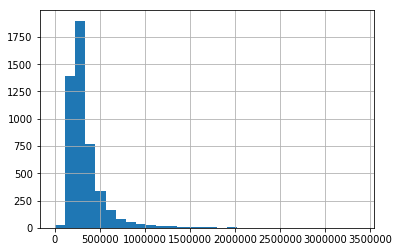

In [13]:
#Investigate the distribution of Median price 2011
df['Median price 2011'].hist(bins = 30)
print('Skew: ',skew(df['Median price 2011']),'Kurtosis: ',kurtosis(df['Median price 2011']))

In [14]:
#The data is very heavily right skewed, and also contains nil values which need to be omitted. 
#I will segment my population at 400,000 to focus my modelling on the bulk of the properties without the long tail
df = df[df['Median price 2011']!=0]
df_lower = df[df['Median price 2011']<=400000] #copy() will surpress below error
df_lower.shape

(3844, 148)

Skew:  0.29057798048330336 Kurtosis:  -0.6121749426408769


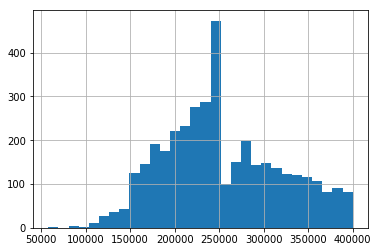

In [15]:
df_lower['Median price 2011'].hist(bins = 30)
print('Skew: ',skew(df_lower['Median price 2011']),'Kurtosis: ',kurtosis(df_lower['Median price 2011']))

The data is clearly not a normal distribution, however removing the tail has substantially fixed skewness to a weak positive. Kurtosis of -0.6 indicates that the distribution is flatter than a normal distribution which should have a kurtosis of +3.
Also - there is a significant step change at the £250k marks, this is due to the change in Stamp Duty from 1% to 3% at this threshold, so sellers are incentivised to list properties just below where this change in rate kicks in

# Follow up with Seun whether this is ok? Is there a simple transform to fix?
## Also see error message below - i know it is being caused because of the relationship of df_lower being a slice of df. Do we want df_lower to be a copy or a slice?

Skew:  0.00916777473638384 Kurtosis:  -0.5207274020192663


C:\Users\andyc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


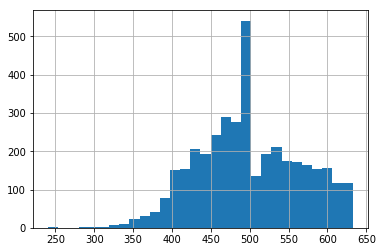

In [16]:
df_lower['Root price'] = np.sqrt(df_lower['Median price 2011'])
df['Root price'] = np.sqrt(df['Median price 2011'])
df_lower['Root price'].hist(bins = 30)
print('Skew: ',skew(df_lower['Root price']),'Kurtosis: ',kurtosis(df_lower['Root price']))

I will now investigate the normality of each of the variables and the correlations with the target variable by defining a custom function which graphs the distribution of the variable and a scatterplot comparing it to the target variable as well as listing skew, kurtosis to assess normality and correlation to the target variable to asses whether it may be a useful feature.

In [17]:
def EDA_graphs(df_lower,n,m):

    cols = df_lower.columns[n:m]

    fig, axes = plt.subplots(nrows = len(cols), ncols = 2, figsize = (12,len(cols)*2), constrained_layout = True)
    sns.set_style('white')

    for i in range(0,len(cols)):
        selection = cols[i]
        if df_lower[selection].dtype != object:
            sns.distplot(df_lower[selection],  ax = axes[i,0])
            sns.regplot(data=df_lower,  x = selection, y = "Median price 2011", scatter_kws={'alpha':0.1}, ax = axes[i,1])
            axes[i,0].set(title = str(i+n) + ") " + selection +"  -  Skew: " + str(round(skew(df_lower[selection]),2)) + 
                          " Kurtosis: " + str(round(kurtosis(df_lower[selection]),2)))
            axes[i,1].set(title = "Correlation to price: " + 
                          str(round(df_lower['Median price 2011'].corr(df_lower[selection]),3)))

    for ax in axes.flat:
        ax.set(xticks = [], yticks = [], ylabel = '', xlabel = '')

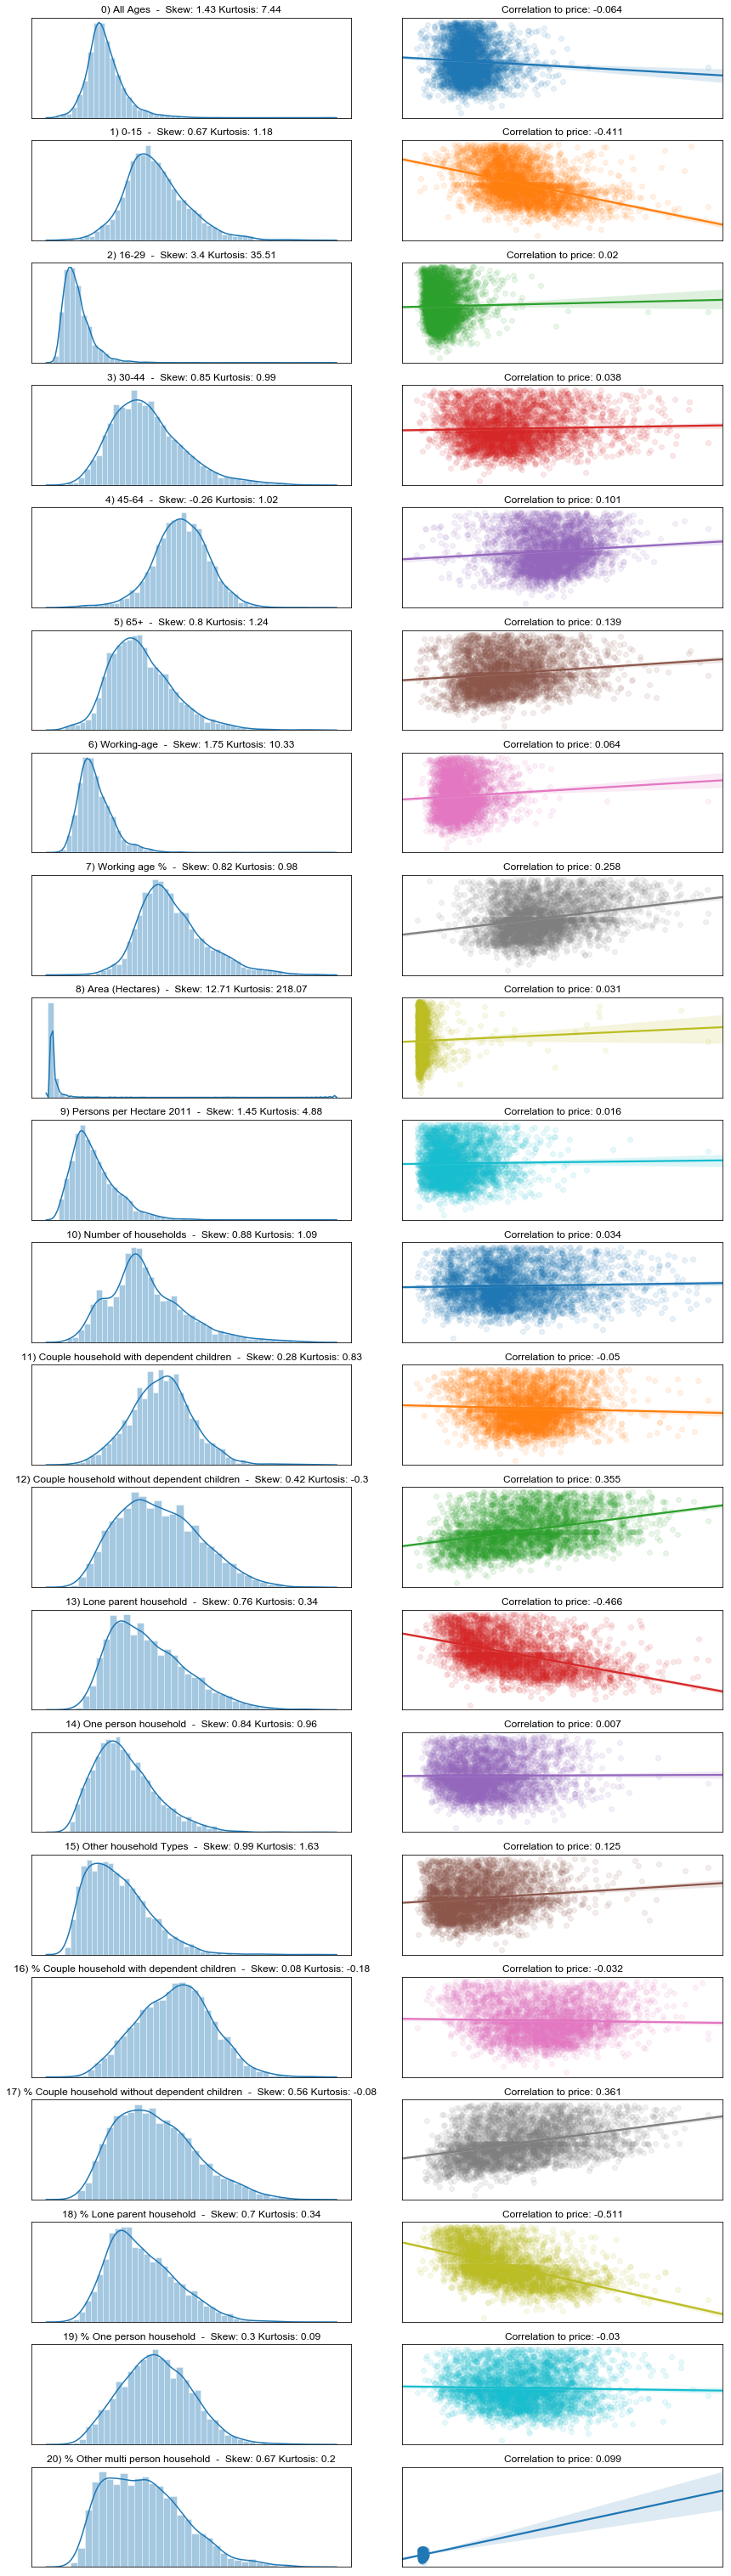

In [18]:
#I will graph the demographic data first
EDA_graphs(df_lower,0,21)

The strongest correlations identified are:

1) Number of 0-15 year olds: Negatively correlated to price at -0.41, this has a slight positive (right) skew of 0.67 which could be corrected with a root transformation and kurtosis of 1.18 indicating lack of extreme outliers and a 'flatter' distribution that normal (which has kurtosis of 3)

7) Working age %: Positively correlated to price at 0.26, slight positive skew of 0.82 and low kurtosis of 0.98

17) Couple household without dependen children %: Positively correlated to price at 0.36, slight positive skew of 0.56 and low kurtosis of -0.08. The non percentage version of this variable was also correlated but not as strongly.

18) Lone parent household %: Negatively correlated at -0.51, slight positive skew of 0.7 and low kurtosis of 0.34. The non percentage version of this variable was also correlated but not as strongly.

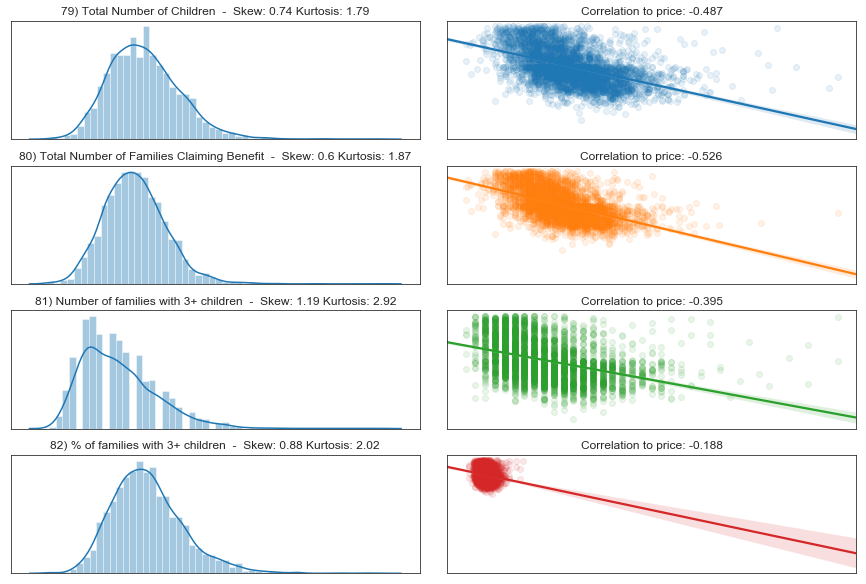

In [19]:
#There are also further demographic fields in the dataset relating to children and benefits
EDA_graphs(df_lower,79,83)

All of the above exhibted varying levels of negative correlations to house prices, each distribution is positively skewed.

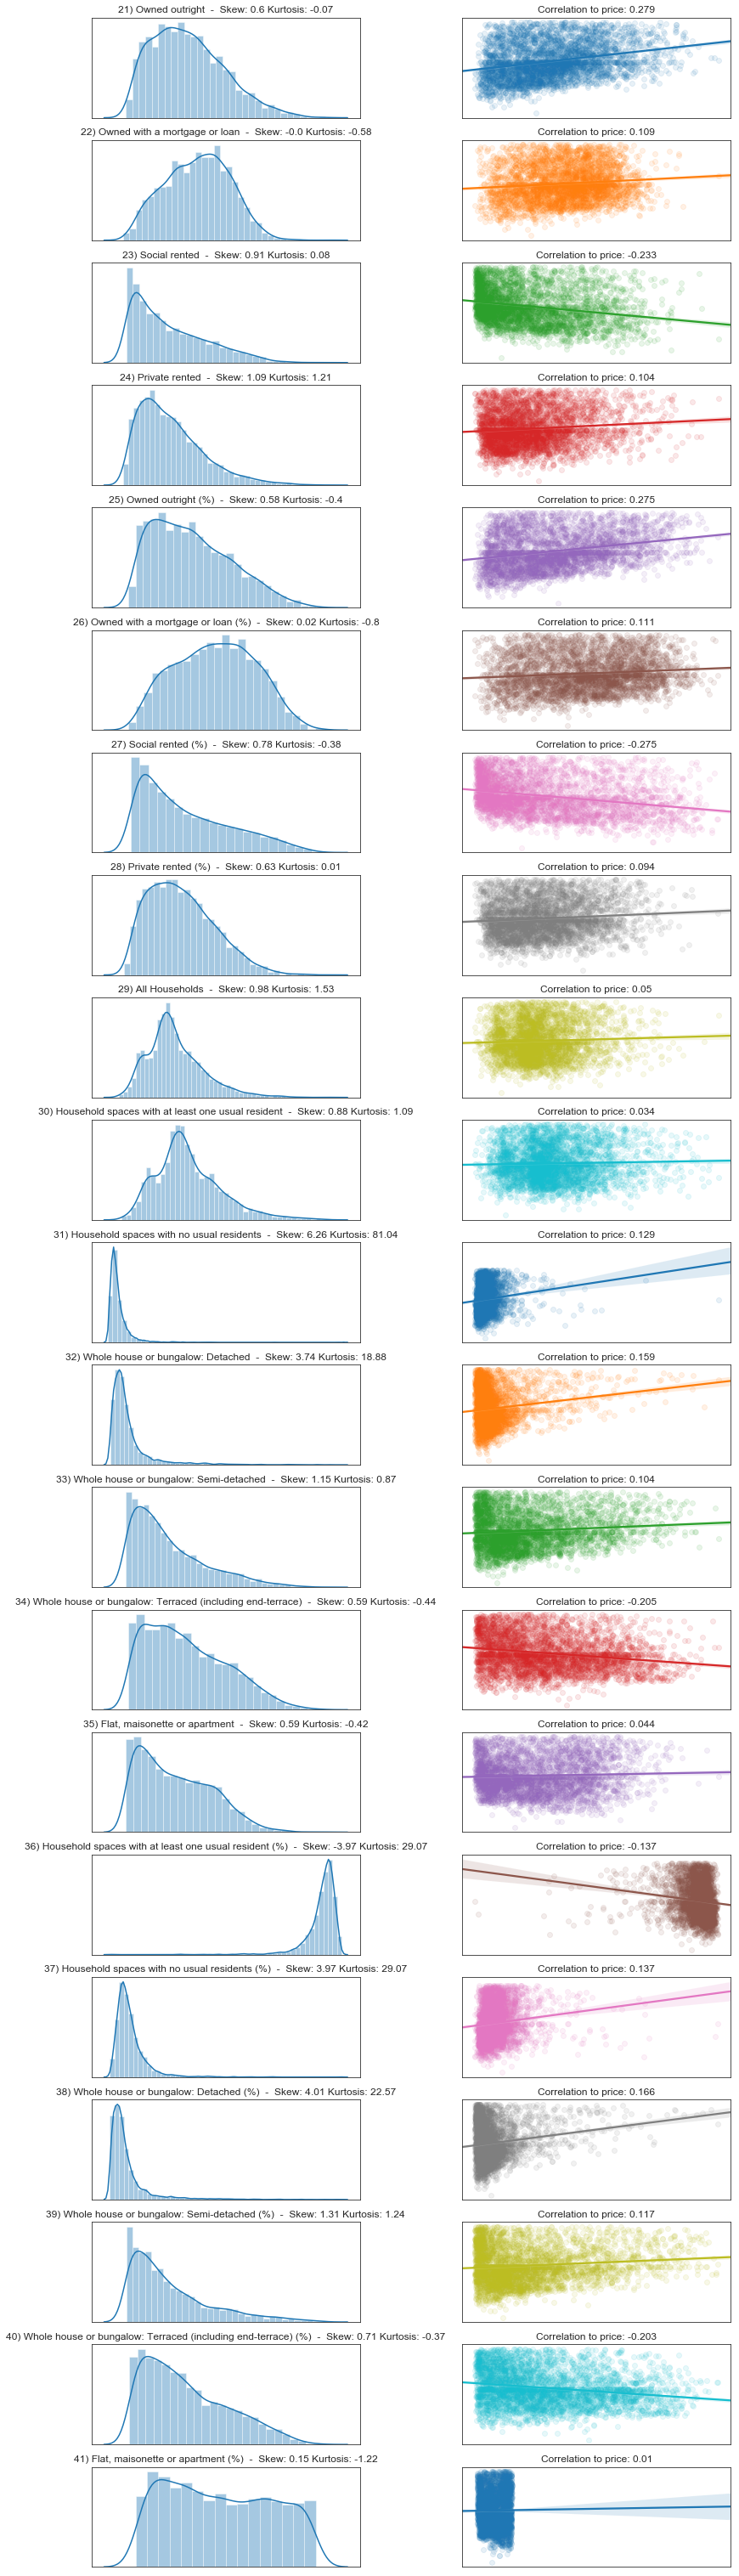

In [20]:
#The next segment of the data considers house ownership, dwelling types and occupancy
EDA_graphs(df_lower,21,42)

21) Owned outright has positive corelation of 0.28 with mild positive skew (0.6), minimal kurtosis (-0.07)

27) Social rented % has negative correlation of -0.28 with mild positive skew (0.78), minimal kurtosis (-0.38)

Everything else exhibits less than 0.25 correlation (either positively or negatively)

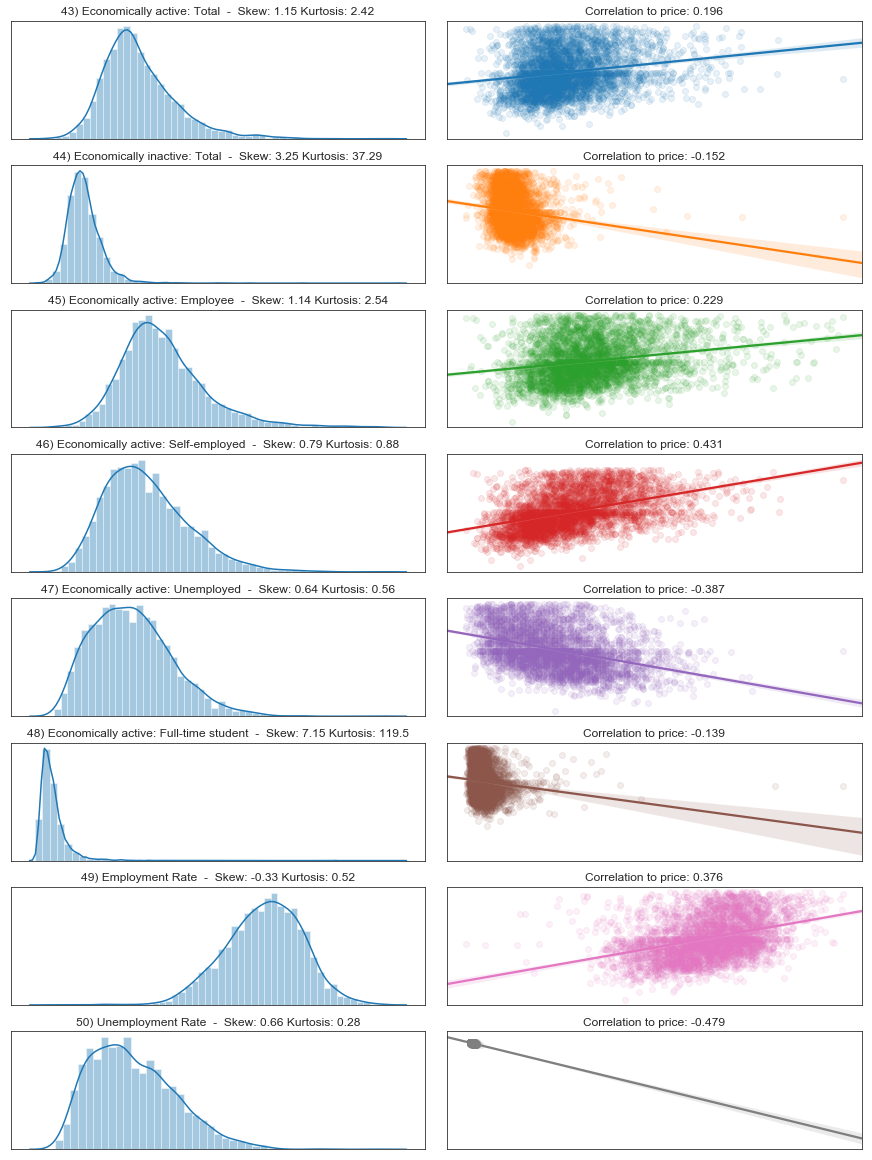

In [21]:
#The next segment of the data considers employment
EDA_graphs(df_lower,43,51)

46) Self employed experiences a positive corelation of 0.43

47) Unemployed experiences a negative correlation of -0.39, both are positively skewed with minimal kurtosis

49) Employment rate is positively corelated at 0.38, with weak negative skew and minimal kurtosis

50) Unemployment rate is negatively correlated at -0.48, with wieak posiive skew and minimal kurtosis

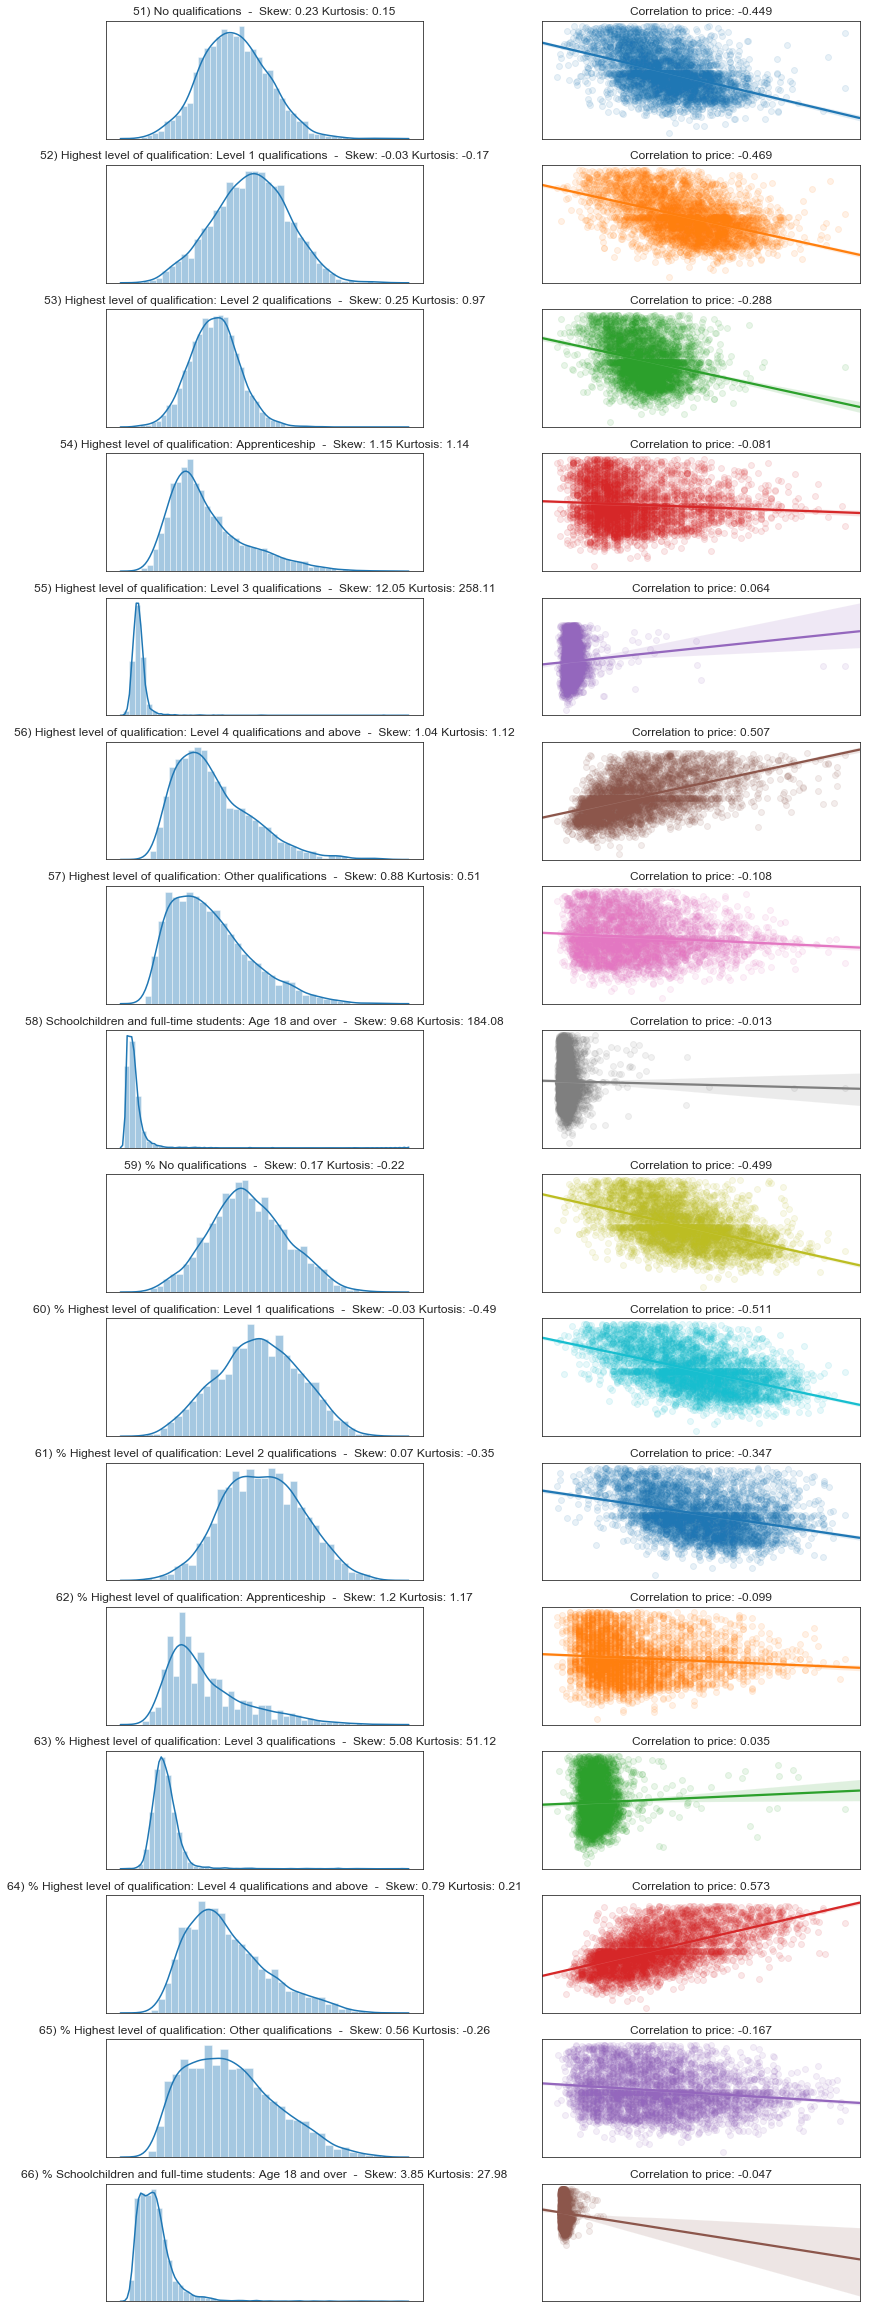

In [22]:
#Education
EDA_graphs(df_lower,51,67)

59), 60) indicating no qualifications or Level 1 qualifications exhibit the strongest negative correlation

65) level 4 and above exhibits the strongest positive correlations

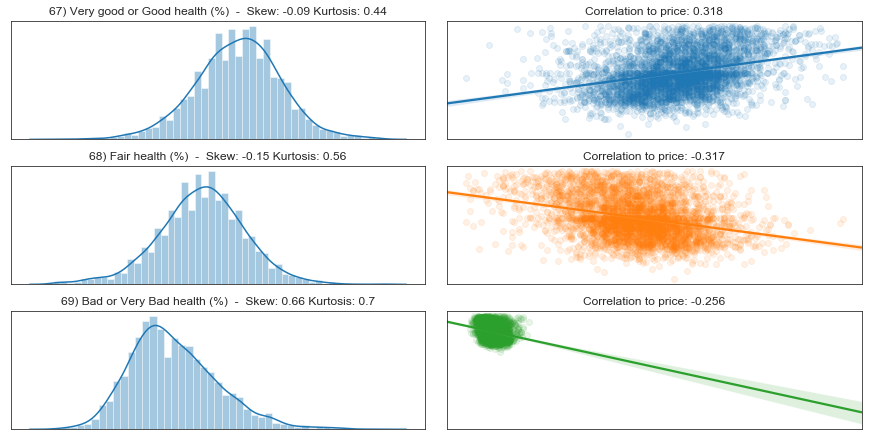

In [23]:
#Healthcare
EDA_graphs(df_lower,67,70)

Good health has a positive correlation, bad health a negative one

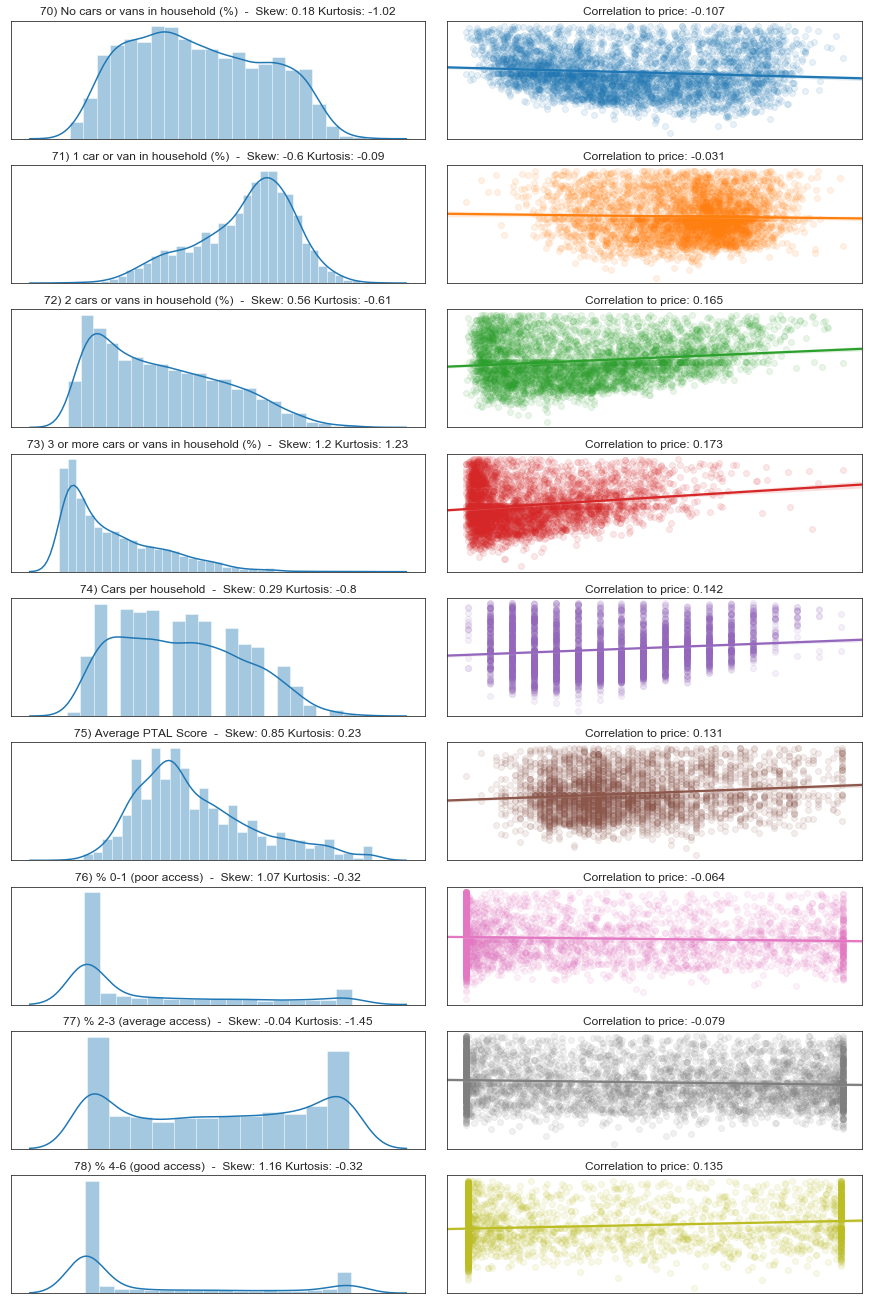

In [24]:
#Transport
EDA_graphs(df_lower,70,79)

### Transport accessability has unusual distributions. Seun - given the lack of any clear correlations is it worth trying to bin these or not??

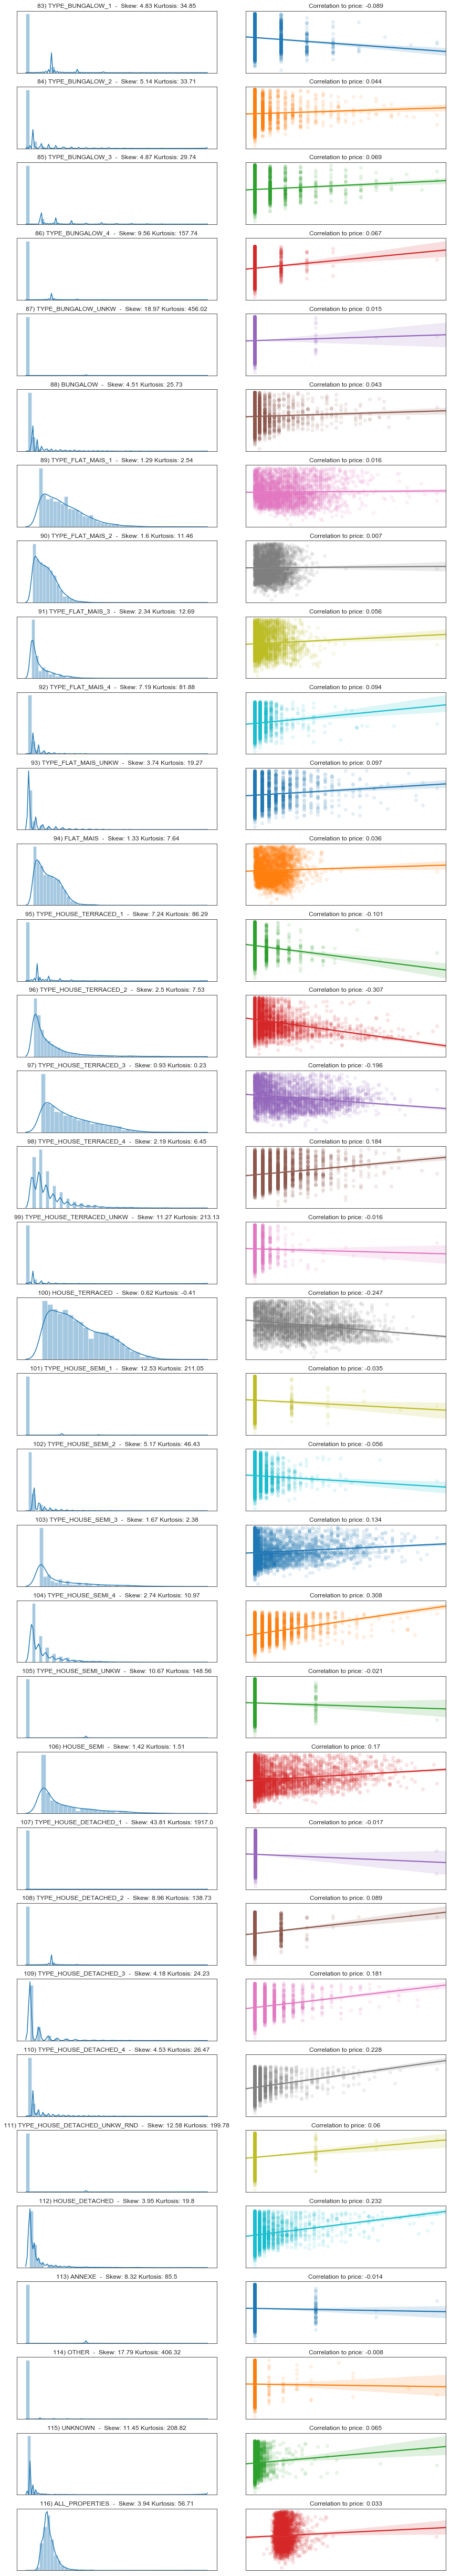

In [25]:
#Transport
EDA_graphs(df_lower,83,117)

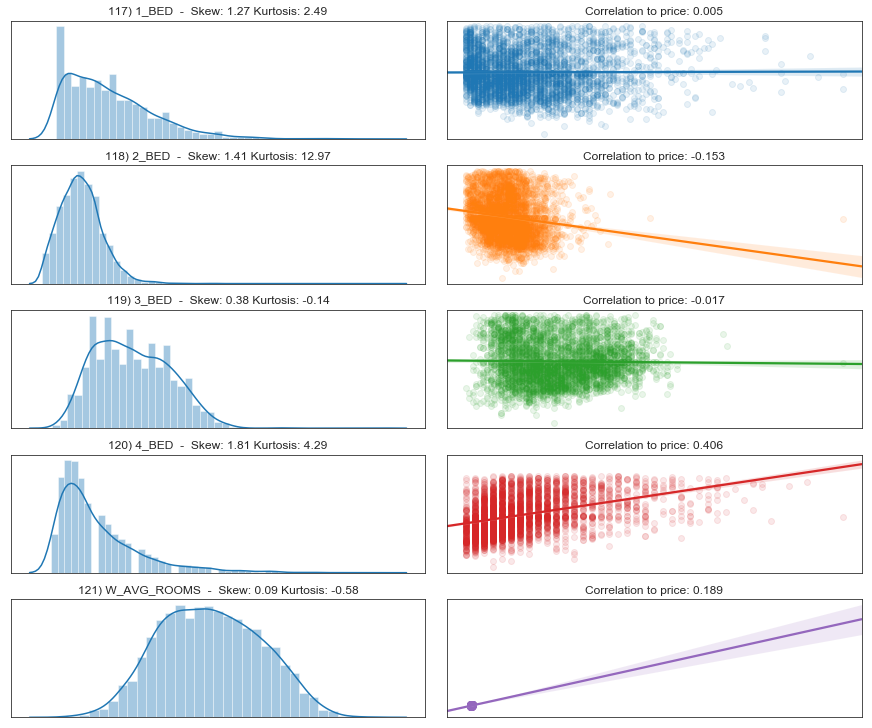

In [26]:
#Numbers of rooms
EDA_graphs(df_lower,117,122)

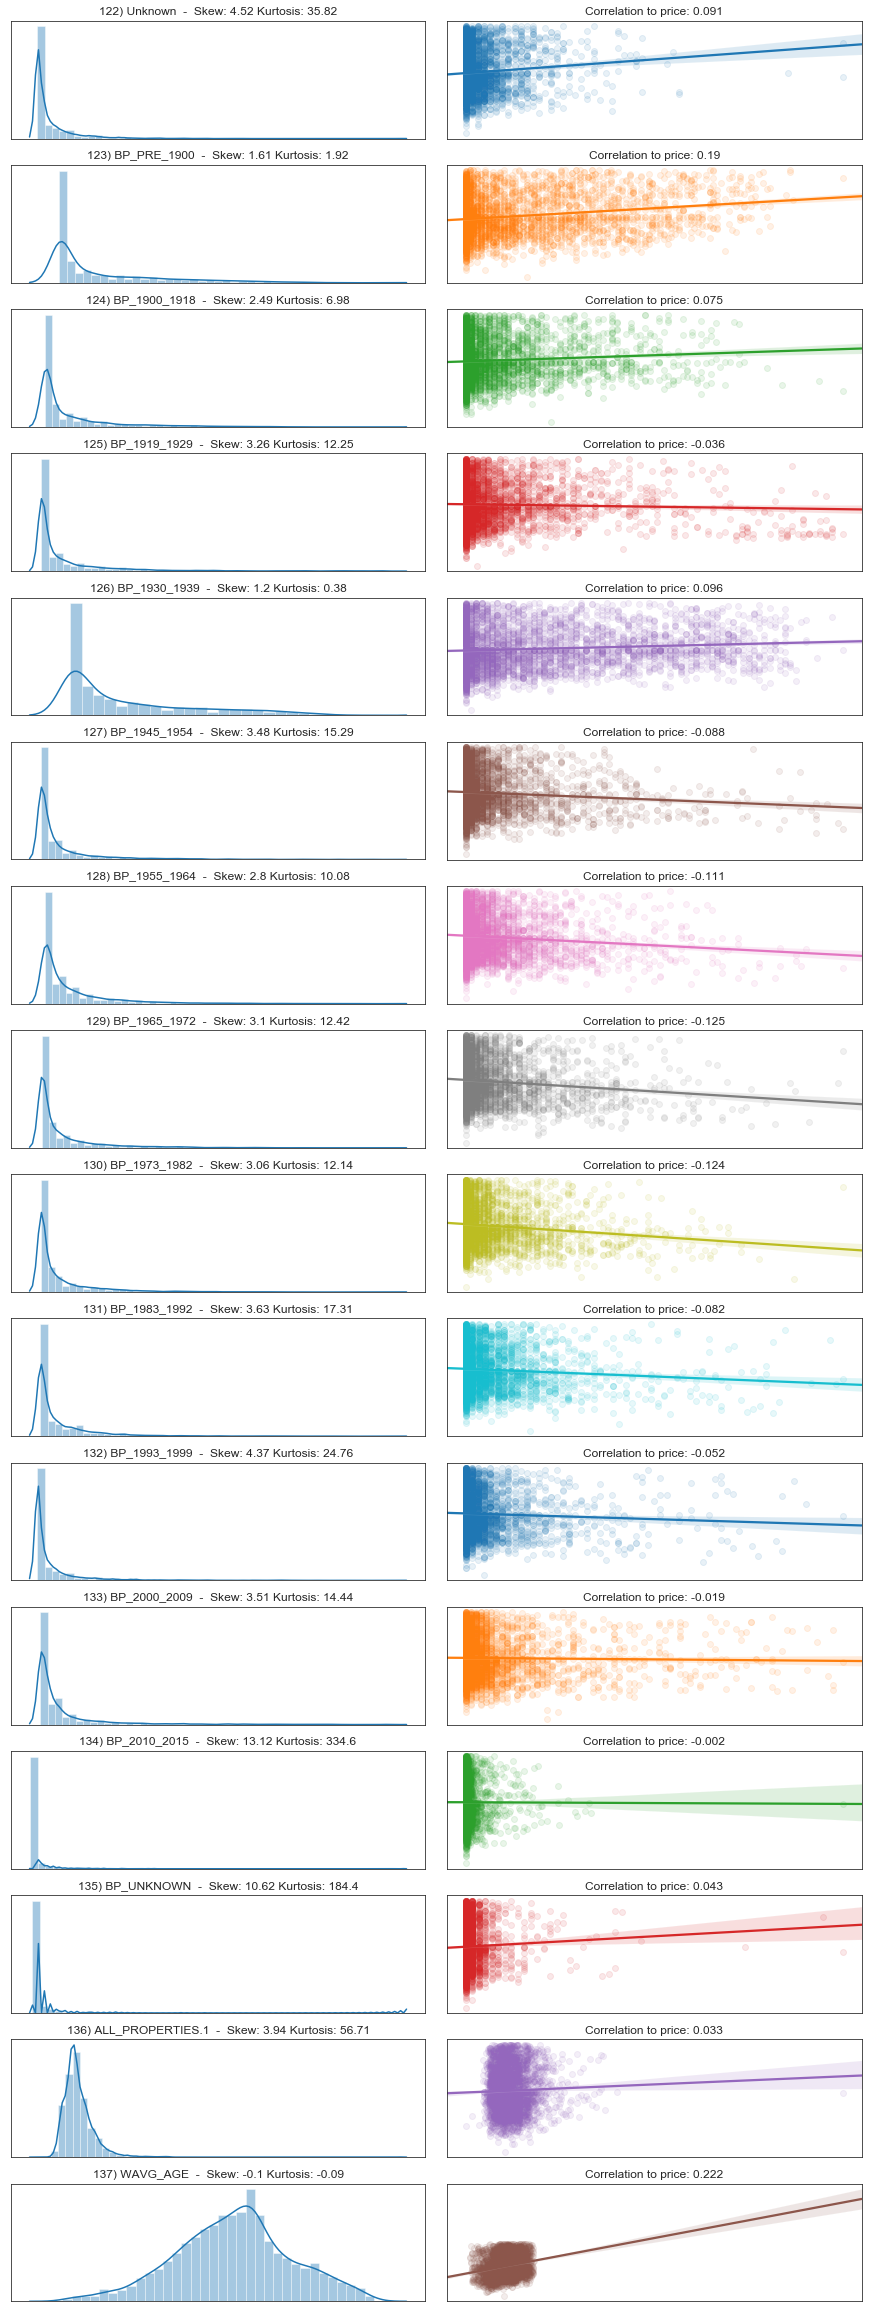

In [27]:
#Property ages
EDA_graphs(df_lower,122,138)

C:\Users\andyc\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\andyc\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


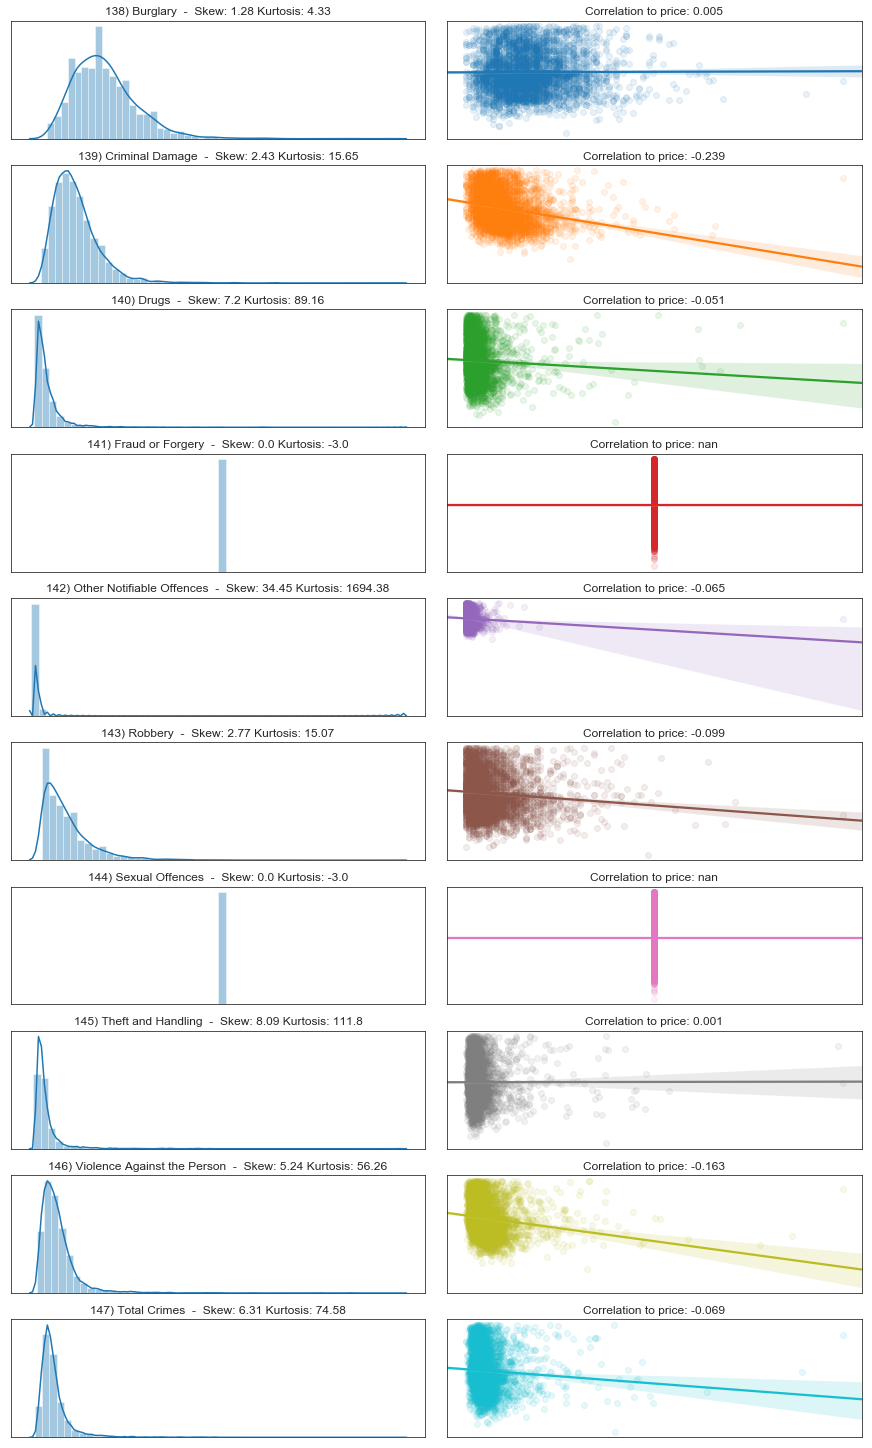

In [28]:
#Crime
EDA_graphs(df_lower,138,148)

# 3 - Feature selection / engineering

In [47]:
#Investigate which fields correlate to the target variable
df_lower_corr = np.abs(df_lower.corr()['Median price 2011']).sort_values(ascending = False)
df_lower_corr.head(30)

Median price 2011                                                     1.000000
Root price                                                            0.996795
% Highest level of qualification: Level 4 qualifications and above    0.573077
Total Number of Families Claiming Benefit                             0.526394
% Highest level of qualification: Level 1 qualifications              0.511224
% Lone parent household                                               0.511183
Highest level of qualification: Level 4 qualifications and above      0.506697
% No qualifications                                                   0.498868
Total Number of Children                                              0.487202
Unemployment Rate                                                     0.478899
Highest level of qualification: Level 1 qualifications                0.469389
Lone parent household                                                 0.465960
No qualifications                                   

In [72]:
#populate a dataframe with t-values
from scipy import stats
cols = df_lower.columns

df_corr = pd.DataFrame()

for i in range(0,len(cols)):
    selection = cols[i]
    t, p = stats.ttest_ind(df_lower['Median price 2011'],df_lower[selection], equal_var = True)
    df_corr.loc[i,0] = cols[i]
    df_corr.loc[i,1] = t
    df_corr.loc[i,2] = p


In [73]:
df_corr

0           1    2
0                                         All Ages  236.282040  0.0
1                                             0-15  237.559044  0.0
2                                            16-29  237.522348  0.0
3                                            30-44  237.487777  0.0
4                                            45-64  237.553503  0.0
5                                              65+  237.715545  0.0
6                                      Working-age  236.785416  0.0
7                                    Working age %  237.824622  0.0
8                                  Area (Hectares)  237.858203  0.0
9                         Persons per Hectare 2011  237.800809  0.0
10                            Number of households  237.258433  0.0
11        Couple household with dependent children  237.775767  0.0
12     Couple household without dependent children  237.748736  0.0
13                           Lone parent household  237.801263  0.0
14                            One person household  237.694991  0.0
15                           Other household Types  237.793512  0.0
16      % Couple household with dependent children  237.871584  0.0
17   % Couple household without dependent children  237.867821  0.0
18                         % Lone parent household  237.875792  0.0
19                          % One person household  237.860951  0.0
20                  % Other multi person household  237.874712  0.0
21                                  Owned outright  237.763892  0.0
22                   Owned with a mortgage or loan  237.714076  0.0
23                                   Social rented  237.725309  0.0
24                                  Private rented  237.737705  0.0
25                              Owned outright (%)  237.869607  0.0
26               Owned with a mortgage or loan (%)  237.862275  0.0
27                               Social rented (%)  237.865161  0.0
28                              Private rented (%)  237.867208  0.0
29                                  All Households  237.240042  0.0
..                                             ...         ...  ...
119                                          3_BED  237.645504  0.0
120                                          4_BED  237.833465  0.0
121                                    W_AVG_ROOMS  237.886726  0.0
122                                        Unknown  237.868188  0.0
123                                    BP_PRE_1900  237.768616  0.0
124                                   BP_1900_1918  237.831940  0.0
125                                   BP_1919_1929  237.840164  0.0
126                                   BP_1930_1939  237.760949  0.0
127                                   BP_1945_1954  237.847327  0.0
128                                   BP_1955_1964  237.837711  0.0
129                                   BP_1965_1972  237.843549  0.0
130                                   BP_1973_1982  237.843427  0.0
131                                   BP_1983_1992  237.856289  0.0
132                                   BP_1993_1999  237.864364  0.0
133                                   BP_2000_2009  237.842532  0.0
134                                   BP_2010_2015  237.864473  0.0
135                                     BP_UNKNOWN  237.881438  0.0
136                               ALL_PROPERTIES.1  237.219165  0.0
137                                       WAVG_AGE  237.817848  0.0
138                                       Burglary  237.871142  0.0
139                                Criminal Damage  237.874417  0.0
140                                          Drugs  237.878005  0.0
141                               Fraud or Forgery  237.888949  0.0
142                      Other Notifiable Offences  237.886894  0.0
143                                        Robbery  237.881597  0.0
144                                Sexual Offences  237.888949  0.0
145                             Theft and Handling  237.837340  0.0
146                    Violence Again

In [ ]:
#Define a custom function to bin all of the numerical columns into 'n' categories
def binning(df,list_n):
    df_binned = pd.DataFrame()
    for c in df.columns:
        if df[c].dtype != 'object':
            for n in list_n:
                df_binned[c+' ('+str(n)+'-binned)'] = pd.qcut(df[c],n,labels = False, duplicates = 'drop')
    return df_binned

In [ ]:
df_binned = binning(df_lower,[5,10,20])
df_binned = df_binned.join(df['Median price 2011'], how = 'inner')
df_binned.head()